# This is a level 1 heading
## 2 This is a level 2 heading
### level 3

all from markdown


## Section 1: Warming up with python and random numbers

Import math, numpy (more math)

In [1]:
#code
from math import *
import numpy as np

Experiment with random numbers.
Evolutionary Strategies like gaussian distributions to the parameters, with lognormal distribution to the evolution of the standard deviations

In [2]:
seed = 0
mean = 0
sdev = 1.0
npts = 3200
x = np.random.normal(mean, sdev, npts)
sx = np.random.lognormal(mean, sdev, npts)

#print(x[0])
#print("gaussian var N(0,1) ", x)
#print("lognormal var ",sx)

In [3]:
#The score can be any function of the errors. RMSE is used here for demonstration purposes, 
#   but in truth, it could be anything. 
# exponential(delta) is fine (and will give very strange results in the evolution -- try it)
def score(delta, start, end, tolerance = 0):
    tmp = delta[start:end]
    tmp *= tmp
    return sqrt(sum(tmp)/(end-start+1))
    #tmp = np.exp(delta[start:end])
    #return sum(tmp)/(end-start+1)

As npts increases, the rmse will tend to the standard deviation. Try it.

The start and end points recognize that we will be training on a subset of the data. Train on 0-N/2, score on N/2+1 to N, for instance.

In [4]:
start = int(0)
end = int(npts/2)
print(x[0])
print(start, end, score(x, start, end))

-0.19401029683983828
0 1600 0.996816605612743


Quick check that the histograms look appropriate:

In [5]:
np.histogram(x,range=(-5,5))

(array([   0,    1,   25,  236,  573, 1629,  454,  144,   64,   26]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]))

In [6]:
np.histogram(sx,range=(0,10))

(array([1581,  812,  354,  171,  100,   65,   27,   21,   15,   13]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

## Acquiring and displaying data

The test input is for station 1151 in the MOS data set, KCGC (Crystal River Airport, FL).
It includes GFS values for T2M, Td, 850-1000mb thickness, rh, and wind speed.
Then t2m-observed, td-observed, t2m-error, td-error.
Once per day, for 579 days of data.

Using csv module for parsing csv file

In [7]:
import csv
import matplotlib
import matplotlib.pyplot as plt

nobs = 579
day = np.zeros((nobs))
t2m_gfs = np.zeros((nobs))
td_gfs = np.zeros((nobs))
thick_gfs = np.zeros((nobs))
rh_gfs = np.zeros((nobs))
speed = np.zeros((nobs))
obs_t2m = np.zeros((nobs))
obs_td = np.zeros((nobs))
terr = np.zeros((nobs))
tderr = np.zeros((nobs))
#could also make up a class 'matchup', and have 579 of those

with open('testin.csv') as csvfile:
    k = 0
    sreader = csv.reader(csvfile, delimiter=",")
    for line in sreader:
        day[k] = float(line[0])
        t2m_gfs[k] = float(line[1])
        td_gfs[k] = float(line[2])
        thick_gfs[k] = float(line[3])
        rh_gfs[k] = float(line[4])
        speed[k] = float(line[5])
        obs_t2m[k] = float(line[6])
        obs_td[k] = float(line[7])
        terr[k] = float(line[8])
        tderr[k] = float(line[9])
        k += 1
csvfile.close()
        
print(day[0],t2m_gfs[0])

0.0 37.85


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


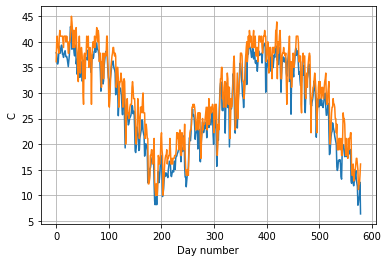

In [8]:
#probably you'd rather see a graphic, so here are t2m_gfs and observed:
#matplotlib.use('Agg') #for batch mode
#matplotlib.use('Qt5Agg')

fig,ax = plt.subplots()
ax.set(xlabel="Day number", ylabel="C")
ax.plot(day,t2m_gfs)
ax.plot(day,obs_t2m)
ax.grid()
fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


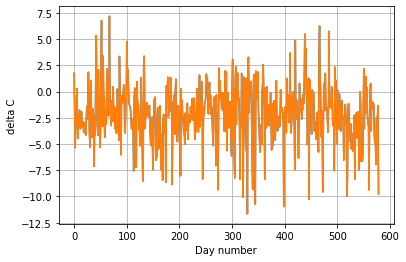

In [9]:
#kluge -- my desk isn't happy with the figure show
plt.close()


fig,ax = plt.subplots()
ax.set(xlabel="Day number", ylabel="delta C")
ax.plot(day,t2m_gfs-obs_t2m)
ax.plot(day,terr)
ax.grid()
fig.show()

In [10]:
#kluge again
plt.close()

#confirm that the difference isn't just optically small:
print((t2m_gfs-obs_t2m-terr).max())

3.9968028886505635e-15


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


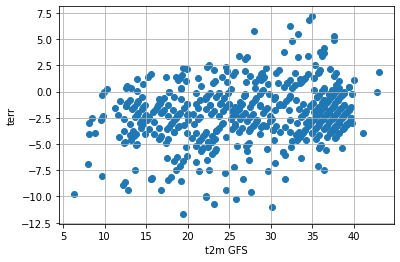

In [11]:
#space for experimenting with plotting variables, say scatter plot of terr vs. the various gfs parameters:
fig,ax = plt.subplots()
ax.set(xlabel="t2m GFS", ylabel="terr")
plt.scatter(t2m_gfs, terr)
ax.grid()
fig.show()

In [12]:
plt.close()

mean = terr.mean()
rmse = sqrt(sum(terr*terr)/nobs)
var  = sqrt(rmse*rmse-mean*mean)

print(terr.mean(), terr.mean()*1.8) #C and F mean errors
print(rmse, var, var/rmse)          #RMSE, variance

r = np.correlate(terr,t2m_gfs) / sqrt(np.correlate(terr,terr)*np.correlate(t2m_gfs,t2m_gfs)) 
print(r,r*r)


-2.150017271157168 -3.8700310880829023
3.487190673166439 2.7455280957850143 0.787318031363057
[-0.53860487] [0.29009521]


As an optical matter, it looks like there's no particular relation between how hot it is, according to the GFS, and how much the GFS is off by -- bias of almost 4 F. 

The bias being 2.15 and rms of 3.50 (rounded), suggests that simply applying a bias correction to the GFS can give substantial improvement on its own -- about 22% reduction in the rmse for removing the bias term.

The correlation (np.correlate is computing covariance, so needs the normalization) being |0.54| suggests that our eyes are largely correct -- linear regression can explain about 29% of the variance. Better than the 22% of simple bias correction, but not by much (depending, of course, on one's needs).

Of course we have more variables available, and no particular reason to believe that linear functions are the only, much less necessarily the best, ones to use.


## Preparing for the Evolutionary Strategy

It is the ambiguity about which the best variables are, what the best functions of them might be, and how best to combine them which encourages looking to evolutionary strategies -- to find improved mappings between the 5 GFS variables at hand and the one item we're trying to predict (or to correct). The principles generalize to many more input variables and many more outputs. Also, one may converge the Evolutionary Strategy towards a Neural Network. There will be an example later.

In [13]:
class matchup:
    #values is a set (tuple or np.ndarray) of parameter values in the matchup
    def __init__(self, values): 
        self.values = values
    
    #display element by element the values of the matchup
    def show(self):
        n = len(self.values)
        for k in range(0,n):
            print(k,self.values[k])
    
    #extract the k-th parameter from the values tuple
    def __getitem__(self,k):
        return(self.values[k])
            

In [14]:
x = matchup((0,1,2,3))
x.show()

#making a toy variable to hold a vector of matchups.
#note syntax for adding new elements.
y = []
y += [x]
y += [x]
print('number of elements in y: ',len(y))

  

0 0
1 1
2 2
3 3
number of elements in y:  2


In [15]:
# Now bring in the data for real work:
z = []

  
with open('testin.csv') as csvfile:
    k = 0
    sreader = csv.reader(csvfile, delimiter=",")
    for line in sreader:
        day = float(line[0])
        t2m_gfs = float(line[1])
        td_gfs = float(line[2])
        thick_gfs = float(line[3])
        rh_gfs = float(line[4])
        speed = float(line[5])
        obs_t2m= float(line[6])
        obs_td = float(line[7])
        terr = float(line[8])
        tderr = float(line[9])
        
        #Note that obs_td, obs_t2m, tderr are being ignored. They can be added to the list.
        #  n.b.: note that it is terr that is used as the variable to predict, not t2m itself. 
        #Model and observation are well-enough correlated that it is the increment 
        #which makes more sense to predict [Krasnopolsky,20NNN]
        m = matchup((day,t2m_gfs,td_gfs,thick_gfs,rh_gfs,speed,terr))
        z.append(m)
        k += 1
    
csvfile.close()

#display the last-added element
print(m)
m.show()

#display it from the matchup vector
print("\n z len = ",len(z),'\n')
z[len(z)-1].show()
print("\n")

#print t2m_gfs specifically -- two different ways of referencing it. 
#The first emphasizes that z[0] is the entity, and we want the element numbered '1' from it. 
#  Remembering that indexing goes from 0 in Python.
print((z[0])[1], z[0][1])
print((z[nobs-1])[1], z[nobs-1][1])


0 578.0
1 6.35
2 -1.65
3 -10.8
4 63.0
5 5.0
6 -9.76

 z len =  579 

0 578.0
1 6.35
2 -1.65
3 -10.8
4 63.0
5 5.0
6 -9.76


37.85 37.85
6.35 6.35


So now z is holding our matchup set of variables. 

We now need a function whose arguments will be a matchup and a set of constants
* make a prediction about what terr should be
* return how incorrect it is

In [16]:
#make a prediction from variables in the matchup x, using constants in the list y
#First prediction method:
def predict1(x,y):
    nx = len(x.values)
    #will ignore matchup[0] (day of observation) and matchup[6], the error term, 
    #  in making prediction
    #Starting point: simple multi-linear regression, a bias term plus 
    #  weights(y[k]) times the predictors
    pred = y[0]
    for k in range(1,nx-1):
        pred += x.values[k]*y[k]
    #print(pred, x.values[nx-1], x[nx-1])
    return (x.values[nx-1]+pred)

#take a set of matchups and evaluate (ultimately, to score) the predictions from predict1
#  note that we're now applying a start and end time -- the training period
def evaluator1(z, start, end, y):
    deltas = np.zeros((end-start+1))
    for k in range (start, end):
        deltas[k-start] = predict1(z[k],y)
    #print(deltas)
    return score(deltas,0,len(deltas))

#n.b. would be desirable to have a general evaluator that takes the 
#    prediction function as an argument as well

Very simplest, let's set up the prediction being just the bias term, 2.15 C, we found above:


In [17]:
weights = np.zeros((6))

weights[0] = 2.15
print(evaluator1(z,0,364,weights)) # score on the first year of data, where we'll do the evolving
print(evaluator1(z,365,nobs-1,weights)) #now for the remainder of the span

2.7426152211650314
2.6833980540126854


In [18]:
#For comparison, try without any corrections:
weights[0] = 0.0
print(evaluator1(z,0,364,weights)) 
print(evaluator1(z,365,nobs-1,weights))

3.428963503798562
3.505670423225644


### towards the evolutionary strategy

Discussion of what exactly is evolutionary will wait for next section. For now, let us continue building the framework. 

There will be a population. Each member of the population will have a set of weights, a set of standard deviations (to specify how the weights may evolve), and a score. It is up to the evaluator, already written, to find the score, also already written. So it is the evolver that is currently needed

In [20]:
sdevs = np.zeros((6))
sdevs[0] = 1.0
weights = np.zeros((6))
weights[0] = 0.0

def evolve(weights, sdevs):
    #sdevs[0]   = np.random.lognormal(sdevs[0],0.25)
    for k in range (0,len(weights)):
        weights[k] = np.random.normal(weights[k],sdevs[k])

evolve(weights,sdevs)
print(weights)
print(sdevs)

[-0.1830074  0.         0.         0.         0.         0.       ]
[1. 0. 0. 0. 0. 0.]


Now to create a class to hold one of the critters (things we're going to evolve). 

In [21]:
class critter:
    score = float(99.0)
    
    def __init__(self, nparm): 
        self.weights = np.zeros((nparm))
        self.sdevs = np.zeros((nparm))
        #self.score = evaluate(matchups, start, end, self.weights)
    
    def init(self, weights, sdevs):
        for k in range(0,len(weights)):
          self.weights[k] = weights[k]
          self.sdevs[k]   = sdevs[k] 
            
    def copy(self, x):
        for k in range(0,len(x.weights)):
          self.weights[k] = x.weights[k]
          self.sdevs[k]   = x.sdevs[k]
        #self.show()

    #display element by element the weights and sdevs
    def show(self):
        n = len(self.weights)
#        for k in range(0,n):
        for k in range(0,1):
            print(k,self.weights[k], self.sdevs[k])
            
    def evolve(self):
        evolve(self.weights, self.sdevs)
    
    def skill(self, matchups, start, end):
        self.score = evaluator1(matchups, start, end, self.weights)


In [22]:
npopulation = 10
population = []

nparameters = 6

for k in range (0,npopulation):
    population.append(critter(nparameters))
    
population[npopulation-1].show()

sdevs[0] = 1.0
for k in range (0,npopulation):
    weights[0] = np.random.normal(0,1)
    population[k].init(weights,sdevs)
    print(k, population[k].weights[0], population[0].weights[0] )

population[0].show()
population[1].show()
population[1].copy(population[0])
population[1].show()

0 0.0 0.0
0 0.1260629848615364 0.1260629848615364
1 -1.4743934103832532 0.1260629848615364
2 1.5419495976405144 0.1260629848615364
3 0.04874820193119693 0.1260629848615364
4 -2.456651256200807 0.1260629848615364
5 -0.9266600321963061 0.1260629848615364
6 0.8293076786591508 0.1260629848615364
7 1.7396387553479897 0.1260629848615364
8 0.6893980955601907 0.1260629848615364
9 0.11318377812612447 0.1260629848615364
0 0.1260629848615364 1.0
0 -1.4743934103832532 1.0
0 0.1260629848615364 1.0


In [23]:
#recall that the poorly-named 'z' is holding the matchups
smin = 9999.
kbest = int(99)

for k in range (0,npopulation):
    population[k].skill(z, 0, 364)
    if (population[k].score < smin):
        kbest = k
        smin = population[k].score 
    
print("k, smin = ",kbest, smin)
population[kbest].show()

k, smin =  7 2.7605140528818555
0 1.7396387553479897 1.0


In [24]:
#swap best in to all slots
#then evolve a new raft of critters from that
#evaluate them
#repeat until limit of generations or happy
genmax = int(300)
population[kbest].show()
population[0].sdevs[0] = 0.25

for gen in range(0,genmax):
    population[0].copy(population[kbest])
    population[0].score = population[kbest].score
    score_best = float(population[0].score)
    smin = score_best
    kbest = 0
    for k in range (1, npopulation):
        population[k].copy(population[0])
        population[k].evolve()
        population[k].skill(z,0,364)
        if (population[k].score < score_best):
            kbest = k
            smin = population[k].score
    if (kbest != 0):
        print("new best ",gen, kbest, smin, score_best)
        population[kbest].show()
        
population[kbest].show()

print("\n")
print(evaluator1(z, 365,nobs,population[kbest].weights))


0 1.7396387553479897 1.0
new best  0 7 2.7529254494682744 2.7605140528818555
0 2.318699516858203 1.0
new best  1 9 2.7417618676818507 2.7529254494682744
0 2.0161452257928816 1.0
new best  4 6 2.74166880503849 2.7417618676818507
0 2.109337919980567 1.0
new best  11 6 2.7416317909158594 2.74166880503849
0 2.106945322985821 1.0
new best  12 4 2.741398320697173 2.7416317909158594
0 2.0862553431896935 1.0
new best  36 2 2.741380778395252 2.741398320697173
0 2.083778469802923 1.0
new best  40 2 2.741346807108397 2.741380778395252
0 2.0776198780019843 1.0
new best  42 3 2.741320344855025 2.741346807108397
0 2.064425034699917 1.0
new best  125 6 2.741320296569906 2.741320344855025
0 2.0645577113542037 1.0
new best  222 1 2.7413202713788993 2.741320296569906
0 2.064635022415112 1.0
new best  236 9 2.7413201489838497 2.7413202713788993
0 2.0652415706375518 1.0
0 2.0652415706375518 1.0


2.7328532666187684


Jupyter and Equations:
For mathematics in the discussion and documents, we can use LaTeX markup with the modification that equations on their own line are noted by $$ before and after, rather than a \begin \end pair.

Inline equation $ Volume = \frac{4.}{3.}*\pi*r^3 $, while offset equation is: $$ Volume = \frac{4.}{3.}*\pi*r^3 $$


